# Checkpoint 2: Mandatory Check-In

- Research Questions (1.5%).
- Feature Engineering (2%).
- Modeling Approaches (3%).
- Preliminary Results (1%).


In [1]:
import zipfile
import numpy as np
import re
import io
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

from data_utils import read_files_from_zip
from feature_utils import crop_and_fill
from eda_utils import show_image


#%load_ext memory_profiler
#from importlib import reload
#reload(data_utils)

## Import data

In [2]:
!ls ../Data

processed_test.pkl   README.md		     sp24_grad_project_data.zip
processed_train.pkl  sp24_grad_project_data


In [3]:
%%time
# Check if our pickles files already exist.
if (os.path.exists('../Data/processed_train.pkl') & os.path.exists('../Data/processed_test.pkl')):
    PICKLED = True
    train_df = pd.read_pickle("../Data/processed_train.pkl")
    test_df = pd.read_pickle("../Data/processed_test.pkl")
else: 
    PICKLED = False

PICKLED

CPU times: user 441 ms, sys: 1.61 s, total: 2.05 s
Wall time: 2.07 s


True

In [4]:
%%time
PICKLED = False
if not PICKLED:
    # Set Date Source
    data_file = '../Data/sp24_grad_project_data.zip'
    
    # Load Test Images
    test_data_images = read_files_from_zip(data_file, r'(test)_images_([\w-]*)\.npz')
    
    # Load Train Images and Labels
    train_data_images = read_files_from_zip(data_file, r'satellite-image-data/([\w-]*)/(train)_images\.npz')
    train_data_labels = read_files_from_zip(data_file, r'satellite-image-data/([\w-]*)/(train)_labels\.npy')

Importing data from zip: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


Found the following datasets:  ['hurricane-matthew', 'flooding-fire']


Importing data from zip: 100%|██████████| 3/3 [00:13<00:00,  4.43s/it]


Found the following datasets:  ['socal-fire', 'midwest-flooding', 'hurricane-matthew']


Importing data from zip: 100%|██████████| 3/3 [00:00<00:00, 1900.45it/s]

Found the following datasets:  ['socal-fire', 'midwest-flooding', 'hurricane-matthew']
CPU times: user 14.9 s, sys: 1.09 s, total: 16 s
Wall time: 16 s


## Data Cleansing

There are many potential enhancements, this seems a reasonable starting point.

Set the output size to match ResNet50 default, 180x180. If the original image is smaller, scale it ~~preserving the aspect ratio~~, noised with random pixels from the original image, and with unscaled original centered. If it’s larger, a random crop is performed.  Black pixels are replaces with random non-black pixels to address images with missing pixels.



Todo: add features indicating whether an image has been cropped or has a scaled background. While 
Most of the larger images are those with nodamaged, so they’re not a major concern. 

In [5]:
%%time

def preprocess_images(image_data_set):
    """
    Preprocess image data, modifies image in place to conserve memory.
    """
    for key in image_data_set.keys():
        print(f'Processing {key} images:')
        
        for i in tqdm(range(len(image_data_set[key]['images']))):
            image_data_set[key]['images'][i] = crop_and_fill(image_data_set[key]['images'][i], 180, background='scaled', replace_scaled=0.2)
"""
# not so fast
if not PICKLED:
    preprocess_images(train_data_images)
    preprocess_images(test_data_images)
"""

CPU times: user 29 µs, sys: 5 µs, total: 34 µs
Wall time: 40.5 µs


'\n# not so fast\nif not PICKLED:\n    preprocess_images(train_data_images)\n    preprocess_images(test_data_images)\n'

dict_keys(['socal-fire', 'midwest-flooding', 'hurricane-matthew'])


(144, 195, 3)

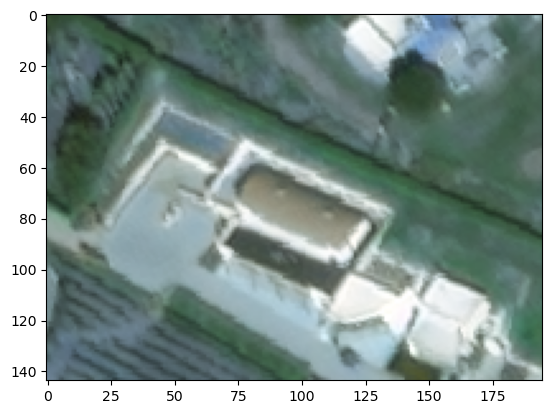

In [6]:
# How did we do?
# Show a image sample
if not PICKLED:
    print(train_data_images.keys())
    image = train_data_images['socal-fire']['images'][0]
    display(image.shape)
    show_image(image)
    plt.show()

## Prepare our data for pickling

In [7]:
# len(test_data_images), len(train_data_images), len(train_data_labels)

In [8]:
type(train_data_images['socal-fire']['images'][0])

numpy.ndarray

In [63]:
PICKLED = False
def data2pd(image_dataset, label_dataset=None):
    # replace type with disaster type
    for key in image_dataset.keys():
        #print(key)
        regex = r'(?:fire|flood|hurricane)'
        matches = re.findall(r'(fire|flood|hurricane)', key)
        disaster_type = matches[0] if matches else None
        image_dataset[key]['type'] = disaster_type
        if label_dataset != None:
            image_dataset[key]['labels'] = label_dataset[key]['labels'] # add labels
    
    df = pd.DataFrame(image_dataset)
    if label_dataset != None:
        df = df.T.explode(['images', 'labels']).drop(columns = ['file']).rename(columns={'labels':'label', 'images':'image'})
    else:
        df = df.T.explode(['images']).drop(columns = ['file']).rename(columns={'images':'image'})
    return df.reset_index()

if not PICKLED:
    train_df = data2pd(train_data_images, train_data_labels)
    test_df = data2pd(test_data_images)

## Data split and augmentation plan (Disaster Type Classification)

We'll use a mix of oversampling and undersampling...
 - oversample the minority class using replacement
 - undersample by randomly delete rows from the majority class to match
   
 - Validation:
     - Sample without replacement 8 samples of each disaster type/level
 - Training:
     - fire:3 has the most (1064-8) representation,
     - flood:1 the next largest (114-8) representation and
     - fire:2 las the least (43-8).
```
fire_0:  7204, remove outliners and sample 53
fire_3:  1064, sample 106
fire_2:  43, augment 71
fire_1:  69, augment 45
flood_0:  6734, remove outliners and sample 53
flood_1:  114, use all
flood_3:  59, augment 55
flood_2:  97, augment 17
```

In [110]:
# Add a size column for the orginal image size
def get_size(img):
    dim = img.shape
    return dim[0] * dim[1]
train_df['size'] = train_df['image'].apply(get_size)

print(train_df.columns)
train_df[['size']].describe().T

Index(['index', 'type', 'image', 'label', 'size'], dtype='object')


,count,mean,std,min,25%,50%,75%,max
size,26535.0,8169.871867,12364.717747,84.0,1936.0,4340.0,10240.0,410464.0


In [132]:
# Create dataset for Disaster Type Classification
classify_type_df = train_df[(train_df.type == 'fire') | (train_df.type == 'flood')]
count_s = classify_type_df.groupby('type')['label'].value_counts()
display(count_s)

# Drop size outliers from over represented columns...
# no damage and fire_3
classify_type_df = classify_type_df.drop(
    classify_type_df[ (classify_type_df['label']==0) & ((classify_type_df['size'] > 10240) | (classify_type_df['size'] < 1936))  ].index
)

classify_type_df = classify_type_df.drop(
    classify_type_df[ (classify_type_df['label']==3) & (classify_type_df['type']=='fire') & ((classify_type_df['size'] > 10240) | (classify_type_df['size'] < 1936))  ].index
)

count_s = classify_type_df.groupby('type')['label'].value_counts()
display(count_s)

type   label
fire   0        7204
       3        1064
       1          69
       2          43
flood  0        6734
       1         114
       2          97
       3          59
Name: count, dtype: int64

type   label
fire   0        2562
       3         477
       1          69
       2          43
flood  0        3616
       1         114
       2          97
       3          59
Name: count, dtype: int64

In [134]:
# Create validation set for modelling.

# We would like for our test set to representive
# of our population so we'll limit it
# sizes in the innerquartile.
classify_type_valid_df = pd.DataFrame()
print('Before: ',classify_type_df.shape)
for T in classify_type_df.type.unique():
    for L in classify_type_df.label.unique():
        #print(f'{T}:{L}')
        sample_df =  classify_type_df[(classify_type_df['type'] == T) & (classify_type_df['label'] == L)
        & ((classify_type_df['size'] <= 10240) & (classify_type_df['size'] >= 1936)) 
        ].sample(8)
        #display(sample_df.shape)
        #print(type(sample_df))
        classify_type_valid_df = pd.concat([sample_df, classify_type_valid_df])
# drop our test sample from the parent df
classify_type_df = classify_type_df.drop(index=classify_type_valid_df.index)       

print('After: ',classify_type_df.shape)
assert(6973 == classify_type_df.shape[0]), 'Invalid parent data size, something looks fishy.'

Before:  (7037, 5)
After:  (6973, 5)


In [150]:
from feature_utils import augment_image

# Now augment data until balanced.
# We'll use a mix of oversampling and undersampling...
# - oversample the minority class using replacement
# - undersample by randomly delete rows from the majority class to match

classify_type_train_df = pd.DataFrame()

# Set a reasonable argumentation limit
sample_size = 150 #int(114 * 1.32)

# We apply flip, rotate augmentation to the
# sample with replacement samples.
# We might duplicate an augmentation if the
# same record is sampled and the augmentation
# is applied.
# Anyway... Cool thing is that we can get as many unique
# balanced training sets as we desire.

for T in classify_type_df.type.unique():
    for L in classify_type_df.label.unique():
        record_size = classify_type_df[(classify_type_df['type'] == T) & (classify_type_df['label'] == L)].shape[0]
        if (record_size > sample_size):
            sample_df = classify_type_df[(classify_type_df['type'] == T) & (classify_type_df['label'] == L)].sample(sample_size)
        else:
            sample_df = classify_type_df[(classify_type_df['type'] == T) & (classify_type_df['label'] == L)]
            classify_type_train_df = pd.concat([sample_df, classify_type_train_df])
            sample_df = classify_type_df[(classify_type_df['type'] == T) & (classify_type_df['label'] == L)].sample(sample_size-record_size, replace=True)
            sample_df['image'] = sample_df['image'].apply(augment_image)
        classify_type_train_df = pd.concat([sample_df, classify_type_train_df])
count_s = classify_type_train_df.groupby('type')['label'].value_counts()
display(count_s)

type   label
fire   0        150
       1        150
       2        150
       3        150
flood  0        150
       1        150
       2        150
       3        150
Name: count, dtype: int64

In [145]:
# Now let's recap our datasets for task A

def show_balance(df):
    display(df.groupby('type')['label'].value_counts())

show_balance(classify_type_valid_df)
show_balance(classify_type_train_df)

type   label
fire   0        8
       1        8
       2        8
       3        8
flood  0        8
       1        8
       2        8
       3        8
Name: count, dtype: int64

type   label
fire   0        150
       1        150
       2        150
       3        150
flood  0        150
       1        150
       2        150
       3        150
Name: count, dtype: int64

## Data split and augmentation plan (Disaster Level Classification)

We'll use a mix of oversampling and undersampling...
 - oversample the minority class using replacement
 - undersample by randomly delete rows from the majority class to match

 - Validation:
    - Sample without replacement N samples of each disaster level
 - Training:
    - Select a sample size such that is a balance between drop/augment

In [187]:
# Create dataset for Disaster Type Classification

# This dataset is a bit more balanced.
classify_level_df = train_df[(train_df.type == 'hurricane')]
show_balance(classify_level_df)

"""
# Drop size outliers from over represented columns...
# We account for this below now...
classify_level_df = classify_level_df.drop(
    classify_level_df[ (classify_level_df['label']==1) & ((classify_level_df['size'] > 10240) | (classify_level_df['size'] < 1936))  ].index
)

show_balance(classify_level_df)
""";

type       label
hurricane  1        5236
           0        2631
           3        1740
           2        1544
Name: count, dtype: int64

In [188]:
# Find a good validation split size
# We'll pick a whole number for our puny human brains.
validation_sample_size = int(classify_level_df.groupby('type')['label'].value_counts().min() * .1945)
print(validation_sample_size)

300


In [189]:
# Find a good augmentation size
# We'll pick a whole number for our puny human brains.
augmentation_size = int(classify_level_df.groupby('type')['label'].value_counts().min() * 1.2955)
print(augmentation_size)

2000


In [190]:
# Create validation set for modelling.

# We would like for our test set to representive
# of our population so we'll limit it
# sizes in the innerquartile.
classify_level_valid_df = pd.DataFrame()
print('Before: ',classify_level_df.shape)
for T in classify_level_df.type.unique():
    for L in classify_level_df.label.unique():
        #print(f'{T}:{L}')
        sample_df =  classify_level_df[(classify_level_df['type'] == T) & (classify_level_df['label'] == L)
        & ((classify_level_df['size'] <= 10240) & (classify_level_df['size'] >= 1936)) 
        ].sample(validation_sample_size)
        #display(sample_df.shape)
        #print(type(sample_df))
        classify_level_valid_df = pd.concat([sample_df, classify_level_valid_df])
# drop our test sample from the parent df
classify_level_df = classify_level_df.drop(index=classify_level_valid_df.index)       

print('After: ',classify_level_df.shape)

assert(9951 == classify_level_df.shape[0]), 'Invalid parent data size, something looks fishy.'

Before:  (11151, 5)
After:  (9951, 5)


In [192]:
from feature_utils import augment_image

# Now augment data until balanced.
# We'll use a mix of oversampling and undersampling...
# - oversample the minority class using replacement
# - undersample by randomly delete rows from the majority class to match

classify_level_train_df = pd.DataFrame()

# Set a reasonable argumentation limit
sample_size = augmentation_size

# We apply flip, rotate augmentation to the
# sample with replacement samples.
# We might duplicate an augmentation if the
# same record is sampled and the augmentation
# is applied.
# Anyway... Cool thing is that we can get as many unique
# balanced training sets as we desire.

for T in classify_level_df.type.unique():
    for L in classify_level_df.label.unique():
        record_size = classify_level_df[
        (classify_level_df['type'] == T) & (classify_level_df['label'] == L)].shape[0]
        if (record_size > sample_size):
            sample_df = classify_level_df[
            (classify_level_df['type'] == T) & (classify_level_df['label'] == L)].sample(sample_size)
        else:
            sample_df = classify_level_df[
            (classify_level_df['type'] == T) & (classify_level_df['label'] == L)]
            classify_level_train_df = pd.concat([sample_df, classify_level_train_df])
            sample_df = classify_level_df[
            (classify_level_df['type'] == T) & (classify_level_df['label'] == L)].sample(
                sample_size-record_size, replace=True)
            sample_df['image'] = sample_df['image'].apply(augment_image)
        classify_level_train_df = pd.concat([sample_df, classify_level_train_df])
count_s = classify_level_train_df.groupby('type')['label'].value_counts()
display(count_s)

type       label
hurricane  0        2000
           1        2000
           2        2000
           3        2000
Name: count, dtype: int64

In [193]:
# Now let's recap our datasets for task B
show_balance(classify_level_valid_df)
show_balance(classify_level_train_df)

type       label
hurricane  0        300
           1        300
           2        300
           3        300
Name: count, dtype: int64

type       label
hurricane  0        2000
           1        2000
           2        2000
           3        2000
Name: count, dtype: int64

---

In [19]:
from eda_utils import show_image

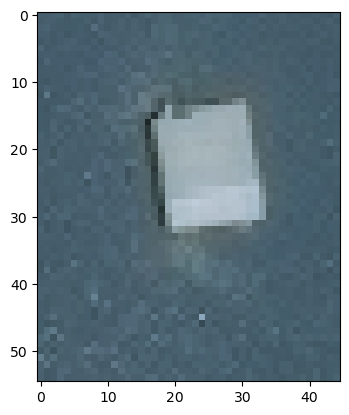

In [143]:
#train_df.iloc[0].image
show_image(classify_type_train_df.iloc[150].image)

In [21]:
%%time
"""
if not PICKLED:
    train_df.to_pickle("../Data/processed_train.pkl")
    test_df.to_pickle("../Data/processed_test.pkl")
    PICKLED = True

!ls -lh ../Data/*.pkl # Large files but this will save us loads of time.
"""

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.2 µs


'\nif not PICKLED:\n    train_df.to_pickle("../Data/processed_train.pkl")\n    test_df.to_pickle("../Data/processed_test.pkl")\n    PICKLED = True\n\n!ls -lh ../Data/*.pkl # Large files but this will save us loads of time.\n'

In [22]:
# Free up some resources
"""
if not PICKLED:
    del(train_data_images)
    del(train_data_labels)
    del(test_data_images)
"""

'\nif not PICKLED:\n    del(train_data_images)\n    del(train_data_labels)\n    del(test_data_images)\n'

## Feature Engineering

Recall our Tasks:

**Disaster Type Classification**
 -  The goal is to build a classifier that can automatically categorize images based on the type of disaster scenario, such as flooding or fire.
   
**Damage Level Classification**
 - The objective is to create a classifier that can automatically determine the level of building damage following a disaster, specifically for hurricanes.


In [23]:
print(train_df.columns)
print(test_df.columns)
print(train_df.type.unique())

df_type = train_df[(train_df['type']=='flood') | (train_df['type']=='fire')]
df_level = train_df[(train_df['type']=='hurrican')]

Index(['type', 'image', 'label', 'size'], dtype='object')
Index(['type', 'image'], dtype='object')
['fire' 'flood' 'hurricane']


In [24]:
# For our Type Classification we want to encode our type and level together.
#f_type['ohe'] = df_type[['label']]
df = df_type[['label', 'type']].copy()

In [25]:
def encode_level(row):
    '''
    if row.label == 0:
        return "none_0"
    else:
        return f'{row.type}_{row.label}'
    '''
    return f'{row.type}_{row.label}'

#df[df.label > 0].apply(lambda df: df['encoded_label'] = df['label'].str
df['coded'] = df.apply(encode_level, axis=1)

In [26]:
df.describe()

,label,type,coded
count,15384,15384,15384
unique,4,2,8
top,0,fire,fire_0
freq,13938,8380,7204


In [27]:
df[df.label > 0].sample(10)

,label,type,coded
socal-fire,3,fire,fire_3
socal-fire,3,fire,fire_3
socal-fire,3,fire,fire_3
socal-fire,3,fire,fire_3
socal-fire,1,fire,fire_1
socal-fire,3,fire,fire_3
midwest-flooding,2,flood,flood_2
socal-fire,3,fire,fire_3
socal-fire,3,fire,fire_3
midwest-flooding,2,flood,flood_2


In [28]:
for code in df.coded.unique():
    print(f'{code}: ', df[df.coded == code].shape[0])

fire_0:  7204
fire_3:  1064
fire_2:  43
fire_1:  69
flood_0:  6734
flood_1:  114
flood_3:  59
flood_2:  97


In [29]:
# even worse... means we'll be valididating our model on just 56 samples
int(df[['coded']].value_counts().min() * 0.2) #* df.coded.nunique()

8

In [30]:
int(df[['coded']].value_counts().min() * 0.8) * df.coded.nunique() # total validation set without augmentation

272

In [31]:
int(114 * .8) * df.coded.nunique() # total validation set with augmentation

728

In [32]:
637/238 # we can more that double our training set with minimal augmentation.

2.676470588235294

In [33]:
(114-8)/(43-8) # 

3.0285714285714285